# Model Selection Part 3/3 - Adaboost & XGBoost Exploration, Comparaison & Tuning

### Short description


Boosting architectures and parameters exploration. This notebook follow **name_model_search**

    - Dataset : 165K products, 938 features, 2 labels to predict (G1 with 9 labels, G2 with 38 labels)
    - Note that classes are highly imbalanced (especially for G2). 
    - We stratify the train/test split on G2 and use balanced class weights parameters when possible.
    - Models tried : 
        - Adaboost
        - XGBoost (with hist method and without dropout)
    - Framework : Chain Classifiers (Predict G1, append prediction to X, predict G2)

**Result & One line Conclusion:** 

* **XGBoost outperforms Adaboost on $G_2$ and is more robust. Further work : Fine tune parameters and define tresholds.**

## Notebook configuration

In [1]:
#Datamanip
import pandas as pd
import numpy as np 
#Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
#Standard
import time 
from IPython.lib.deepreload import reload as dreload

#Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import ClassifierChain
#Evaluation
from sklearn import metrics
from eml.model_eval import classifier_metrics, get_classification_report, plot_confusion_matrix

#Settings
pd.set_option("display.max_columns", 200, "display.max_rows", 200)
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#Load dataset
df_modified = pd.read_csv(r'C:\Users\Antoine\Coding Bootcamp\Open Food Facts\data_training_names.csv', low_memory=False)
df_copy = df_modified.copy(deep=True)

In [4]:
def duplicates_pnns(df): 
    def other_pnns(row): return row['pnns_groups_3']
    copy_loc = df.loc[df['pnns_groups_2'] != df['pnns_groups_3']].copy(deep=True)
    copy_loc['pnns_groups_2'] = copy_loc.apply(lambda row: other_pnns(row=row), axis=1)
    df = df.append(copy_loc)
    return df
test = df_copy.sample(2000)
test = duplicates_pnns(test)
test.shape

(2943, 946)

In [5]:
%%time
df = duplicates_pnns(df_modified)

Wall time: 5.19 s


In [95]:
df_modified.shape

(167548, 946)

In [96]:
df.shape

(243166, 946)

In [5]:
features = df_modified.drop(columns=['pnns_groups_1', 'pnns_groups_2', 'pnns_groups_3', 'pnns_groups_4', 'code', 'url', 'ingredients', 'product_name'])
target = df_modified[['pnns_groups_1', 'pnns_groups_2']]

In [9]:
target_pnns1 = df_modified['pnns_groups_1']

In [6]:
#Target encoding
le = LabelEncoder()
le.fit(target['pnns_groups_1'])
encoded_target_1 = le.transform(target['pnns_groups_1']).reshape(-1,1)
le_2 = LabelEncoder()
le_2.fit(target['pnns_groups_2'])
encoded_target_2 = le_2.transform(target['pnns_groups_2']).reshape(-1,1)
encoded_target = np.append(encoded_target_1, encoded_target_2, axis=1)

In [11]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(features, target_pnns1, test_size=0.2, random_state=42, stratify=target)
X_train_sample = X_train.sample(20000, random_state=1)
y_train_sample = y_train.sample(20000, random_state=1)
X_train.shape, y_train.shape

((134038, 938), (134038,))

## Adaboost - Predict $G_1$

### On sample data train

In [12]:
%%time
dt = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=3, 
    min_weight_fraction_leaf=0.0, 
    max_features='log2', 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight='balanced', 
    ccp_alpha=0.0
    )

ada = AdaBoostClassifier(
    base_estimator=dt, 
    n_estimators=500, 
    learning_rate=0.08, 
    algorithm='SAMME.R', 
    random_state=21
    )


ada.fit(X_train, y_train)
y_preds_train = ada.predict(X_train)
y_preds_test = ada.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 92.24%
Recall : 91.52%
Precision : 92.25%
F1-score : 91.70%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 83.24%
Recall : 81.26%
Precision : 83.19%
F1-score : 81.87%


Wall time: 11min 27s


In [13]:
get_classification_report(y_test=y_test, y_pred=y_preds_test, model='adaboost', sortby='support')

,adaboost_precision,adaboost_recall,adaboost_f1-score,adaboost_support
macro avg,0.83,0.81,0.82,33510.00
weighted avg,0.84,0.83,0.83,33510.00
sugary snacks,0.88,0.92,0.90,7244.00
milk and dairy products,0.93,0.85,0.89,4425.00
fish meat eggs,0.89,0.84,0.86,4057.00
beverages,0.87,0.86,0.87,3864.00
cereals and potatoes,0.82,0.73,0.77,3476.00
composite foods,0.70,0.81,0.75,3462.00
fruits and vegetables,0.62,0.79,0.70,2822.00
fat and sauces,0.90,0.78,0.83,2085.00


In [14]:
get_classification_report(y_test=y_test, y_pred=y_preds_test, model='adaboost', sortby='precision')

,adaboost_precision,adaboost_recall,adaboost_f1-score,adaboost_support
milk and dairy products,0.93,0.85,0.89,4425.00
fat and sauces,0.90,0.78,0.83,2085.00
fish meat eggs,0.89,0.84,0.86,4057.00
sugary snacks,0.88,0.92,0.90,7244.00
beverages,0.87,0.86,0.87,3864.00
salty snacks,0.87,0.73,0.79,2075.00
weighted avg,0.84,0.83,0.83,33510.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.83,0.81,0.82,33510.00
cereals and potatoes,0.82,0.73,0.77,3476.00


In [15]:
%%time
dt = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=3, 
    min_weight_fraction_leaf=0.0, 
    max_features=0.33, 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight='balanced', 
    ccp_alpha=0.0
    )

ada = AdaBoostClassifier(
    base_estimator=dt, 
    n_estimators=50, 
    learning_rate=0.08, 
    algorithm='SAMME.R', 
    random_state=21
    )


ada.fit(X_train, y_train)
y_preds_train = ada.predict(X_train)
y_preds_test = ada.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 96.45%
Recall : 96.24%
Precision : 96.09%
F1-score : 96.07%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 81.23%
Recall : 79.25%
Precision : 80.54%
F1-score : 79.73%


Wall time: 21min 34s


In [16]:
%%time
dt = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=3, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight='balanced', 
    ccp_alpha=0.0
    )

ada = AdaBoostClassifier(
    base_estimator=dt, 
    n_estimators=50, 
    learning_rate=0.08, 
    algorithm='SAMME.R', 
    random_state=21
    )


ada.fit(X_train, y_train)
y_preds_train = ada.predict(X_train)
y_preds_test = ada.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 95.70%
Recall : 95.44%
Precision : 95.36%
F1-score : 95.31%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 83.88%
Recall : 81.96%
Precision : 83.44%
F1-score : 82.52%


Wall time: 5min 5s


In [17]:
%%time
learnings_rates = [0.1, 0.4, 0.8]
precisions = []
dt = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=3, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight='balanced', 
    ccp_alpha=0.0
    )
for lr in learnings_rates :
    ada = AdaBoostClassifier(
        base_estimator=dt, 
        n_estimators=100, 
        learning_rate=lr, 
        algorithm='SAMME.R', 
        random_state=21
        )
    ada.fit(X_train_sample, y_train_sample)
    y_preds_test = ada.predict(X_test)
    prec = metrics.precision_score(y_test, y_preds_test, average ='macro', zero_division=0)
    precisions.append(prec)

Wall time: 2min 10s


<AxesSubplot:>

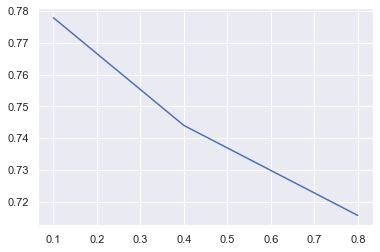

In [19]:
sns.lineplot(x=learnings_rates, y=precisions)

In [20]:
dt = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=3, 
    min_weight_fraction_leaf=0.0, 
    max_features='sqrt', 
    random_state=42, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight='balanced', 
    ccp_alpha=0.0
    )

ada = AdaBoostClassifier(
    base_estimator=dt, 
    n_estimators=100, 
    learning_rate=0.01, 
    algorithm='SAMME.R', 
    random_state=21
    )


ada.fit(X_train_sample, y_train_sample)
y_preds_test = ada.predict(X_test)
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')
prec = metrics.precision_score(y_test, y_preds_test, average ='macro', zero_division=0)
precisions.append(prec)
learnings_rates.append(0.01)

Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 80.41%
Recall : 77.88%
Precision : 80.52%
F1-score : 78.85%




<AxesSubplot:>

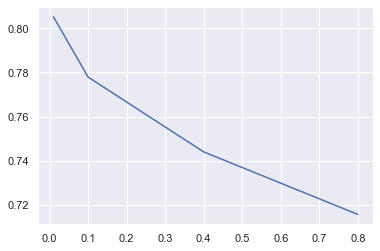

In [21]:
sns.lineplot(x=learnings_rates, y=precisions)

**Before tuning more the parameters of Adaboost, we will explore XGBoost to see it capabilities for this task.**

## Explore XGBoost

In [42]:
#Imports
import xgboost as xgb
from xgboost import XGBClassifier

In [34]:
#Encode Label (G1)
le = LabelEncoder()
le.fit(target['pnns_groups_1'])
encoded_target = le.transform(target['pnns_groups_1'])

In [38]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(features, encoded_target, test_size=0.2, random_state=42, stratify=encoded_target)
X_train_sample = X_train[:20000]
y_train_sample = y_train[:20000]
X_train.shape, y_train.shape

((134038, 938), (134038,))

### Predict $G_1$ with $XGBoost$ on sample data

We follow some advices from Towards Data Science Articles for tuning parameters.
This include : 

    - Tuning max_samples between 0.8 and 1.
    - Start with small max_depth and increase it until no performance gain
    - Start with 100 estimators and lr=0.01, then increase estimators without touching lr (or decrease lr)

In [53]:
model = XGBClassifier(
    learning_rate = 0.01, 
    n_estimators=100, 
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.1,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 23.4 s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 68.27%
Recall : 61.72%
Precision : 83.14%
F1-score : 67.15%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 68.76%
Recall : 65.96%
Precision : 72.85%
F1-score : 67.38%




In [54]:
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 66.28%
Recall : 59.50%
Precision : 81.60%
F1-score : 65.00%




#### Increase learning rate & max_depth

In [55]:
model = XGBClassifier(
    learning_rate = 0.05, 
    n_estimators=100, 
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.25,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 40.4 s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 82.85%
Recall : 80.36%
Precision : 84.26%
F1-score : 81.67%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 79.36%
Recall : 76.54%
Precision : 80.71%
F1-score : 77.89%




#### Keep learning rate value, add estimators and increase max depth

In [56]:
model = XGBClassifier(
    learning_rate = 0.05, #same
    n_estimators=150, #+50
    max_depth=12, #+4
    subsample=0.8,
    colsample_bytree=0.25,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 1min 15s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 86.70%
Recall : 84.89%
Precision : 87.18%
F1-score : 85.74%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 82.00%
Recall : 79.70%
Precision : 82.34%
F1-score : 80.65%




We observe 2% increase in precision on test set.

#### Double number of estimators and decrease learning rate

In [58]:
model = XGBClassifier(
    learning_rate = 0.025, 
    n_estimators=300, 
    max_depth=12,
    subsample=0.87,
    colsample_bytree=0.4,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 3min 19s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 88.28%
Recall : 86.70%
Precision : 88.58%
F1-score : 87.40%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 82.41%
Recall : 80.24%
Precision : 82.56%
F1-score : 81.06%




### Change regularization parameters and prevent overfitting with col_sample

In [65]:
model = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=0.5,
    colsample_bynode=0.9, 
    colsample_bytree=0.7, 
    eval_metric='mlogloss',
    gamma=0.5, 
    gpu_id=0, 
    importance_type='gain',
    learning_rate=0.02, #-0.03
    max_delta_step=0,
    max_depth=12, #same
    min_child_weight=1, 
    n_estimators=300, #+150
    n_jobs=-1,
    num_class=9, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=0, 
    reg_alpha=0.15, 
    reg_lambda=0.85, 
    scale_pos_weight=None,
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    validate_parameters=1, 
    verbosity=None)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 4min 23s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 86.79%
Recall : 85.16%
Precision : 87.19%
F1-score : 85.90%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 81.11%
Recall : 79.05%
Precision : 81.36%
F1-score : 79.84%




### Train on full dataset

In [66]:
model = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=0.7,
    colsample_bynode=0.9, 
    colsample_bytree=0.6, 
    eval_metric='mlogloss',
    gamma=0.5, 
    gpu_id=0, 
    importance_type='gain',
    learning_rate=0.02, 
    max_delta_step=0,
    max_depth=18, 
    min_child_weight=1, 
    n_estimators=400, 
    n_jobs=8,
    num_class=9, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=0, 
    reg_alpha=0.15, 
    reg_lambda=0.85, 
    scale_pos_weight=None,
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    validate_parameters=1, 
    verbosity=None)
%time model.fit(X_train, y_train)
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 30min 38s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 89.35%
Recall : 88.15%
Precision : 89.47%
F1-score : 88.66%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 85.61%
Recall : 83.96%
Precision : 85.58%
F1-score : 84.57%




In [70]:
get_classification_report(y_test=le.inverse_transform(y_test), y_pred=le.inverse_transform(y_preds_test), model='xgboost', sortby='precision')

,xgboost_precision,xgboost_recall,xgboost_f1-score,xgboost_support
milk and dairy products,0.93,0.88,0.90,4425.00
fat and sauces,0.92,0.85,0.89,2085.00
sugary snacks,0.90,0.93,0.92,7244.00
fish meat eggs,0.90,0.86,0.88,4058.00
salty snacks,0.88,0.78,0.83,2075.00
cereals and potatoes,0.87,0.79,0.83,3476.00
weighted avg,0.86,0.86,0.86,33510.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.86,0.84,0.85,33510.00
fruits and vegetables,0.79,0.74,0.76,2822.00


In [71]:
model = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=0.7,
    colsample_bynode=0.9, 
    colsample_bytree=0.6, 
    gamma=0.6, 
    gpu_id=0, 
    importance_type='gain',
    learning_rate=0.01, 
    max_depth=25, 
    min_child_weight=1, 
    n_estimators=500, 
    num_class=9, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=0, 
    reg_alpha=0.1, 
    reg_lambda=0.9, 
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    )
%time model.fit(X_train, y_train)
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 1h 18s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 89.64%
Recall : 88.50%
Precision : 89.77%
F1-score : 88.98%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 85.66%
Recall : 84.01%
Precision : 85.59%
F1-score : 84.60%




### Save best model XGBoost

In [79]:
model.save_model('xgboost_group1.model')

### Load model and Classification Report

In [80]:
xgb_model_latest = xgboost.XGBClassifier()
xgb_model_latest.load_model("xgboost_group1.model")
y_preds = xgb_model_latest.predict(X_test)
classifier_metrics(y_test=y_test, y_preds=y_preds, average='macro', model='Test Set Class1 - XGBoost on full')

Test Set Class1 - XGBoost on full Classification Metrics :
-------------------
Accuracy : 85.66%
Recall : 84.01%
Precision : 85.59%
F1-score : 84.60%




In [72]:
get_classification_report(y_test=le.inverse_transform(y_test), y_pred=le.inverse_transform(y_preds_test), model='xgboost', sortby='precision')

,xgboost_precision,xgboost_recall,xgboost_f1-score,xgboost_support
milk and dairy products,0.93,0.88,0.90,4425.00
fat and sauces,0.91,0.86,0.88,2085.00
sugary snacks,0.90,0.93,0.92,7244.00
fish meat eggs,0.90,0.87,0.88,4058.00
salty snacks,0.89,0.78,0.83,2075.00
cereals and potatoes,0.87,0.79,0.83,3476.00
weighted avg,0.86,0.86,0.86,33510.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.86,0.84,0.85,33510.00
fruits and vegetables,0.79,0.74,0.76,2822.00


### Some features importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

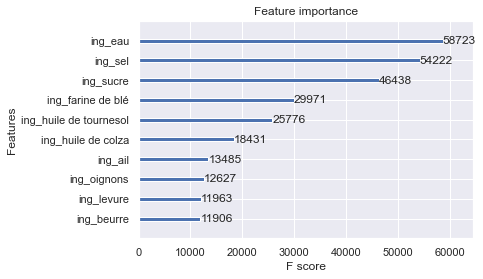

In [74]:
xgb.plot_importance(model, max_num_features=10)

In [75]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
features_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

## Predict $G_2$ with $XGBoost$ and $G_1$ prediction

### Configuration

In [10]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from eml.model_eval import classifier_metrics, get_classification_report, plot_confusion_matrix
from sklearn.multioutput import ClassifierChain
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
features = df_modified.drop(columns=['pnns_groups_1', 'pnns_groups_2', 'pnns_groups_3', 'pnns_groups_4', 'code', 'url', 'ingredients', 'product_name'])
target = df_modified[['pnns_groups_1', 'pnns_groups_2']]

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target['pnns_groups_2'])
encoded_target = le.transform(target['pnns_groups_2'])
X_train, X_test, y_train, y_test = train_test_split(features, encoded_target, test_size=0.2, random_state=42, stratify=encoded_target)

### Add $G_1$ predictions to features

In [12]:
xgb_model_latest = XGBClassifier()
xgb_model_latest.load_model("xgboost_group1.model")
pnns_1_preds_train = xgb_model_latest.predict(X_train)
pnns_1_preds_test = xgb_model_latest.predict(X_test)

In [13]:
X_train = np.append(X_train, pnns_1_preds_train.reshape(-1,1), axis=1)
X_test = np.append(X_test, pnns_1_preds_test.reshape(-1,1), axis=1)
X_train_sample = X_train[:20000]
y_train_sample = y_train[:20000]
X_train.shape, y_train.shape

((134038, 939), (134038,))

### Parameters testing on sample data

In [100]:
model = XGBClassifier(
    learning_rate = 0.1, 
    n_estimators=100, 
    max_depth=15,
    subsample=0.85,
    colsample_bytree=0.45,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class2')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class2')

Wall time: 3min 7s
Train Set Class2 Classification Metrics :
-------------------
Accuracy : 87.83%
Recall : 84.78%
Precision : 88.76%
F1-score : 86.48%


Test Set Class2 Classification Metrics :
-------------------
Accuracy : 75.94%
Recall : 69.03%
Precision : 76.33%
F1-score : 71.76%




In [102]:
get_classification_report(y_test=le.inverse_transform(y_train_sample), y_pred=le.inverse_transform(y_preds_train), model='xgboost', sortby='precision')

,xgboost_precision,xgboost_recall,xgboost_f1-score,xgboost_support
fruit nectars,1.00,0.70,0.82,20.00
sandwiches,0.97,0.92,0.94,154.00
ice cream,0.97,0.97,0.97,292.00
pastries,0.96,0.88,0.92,214.00
pizza pies and quiche,0.96,0.94,0.95,213.00
soups,0.96,0.94,0.95,154.00
dairy desserts,0.96,0.84,0.90,476.00
salty and fatty products,0.95,0.91,0.93,558.00
fish and seafood,0.95,0.88,0.91,642.00
bread,0.95,0.90,0.93,470.00


In [116]:
model = XGBClassifier(
    learning_rate = 0.1, 
    n_estimators=1, 
    max_depth=2,
    subsample=0.85,
    colsample_bytree=0.45,
    gamma=1,
    objective= 'multi:softprob',
    eval_metric='mlogloss',
    num_class= 9,
    tree_method='gpu_hist', 
    use_label_encoder=False)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class2')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class2')

Wall time: 1.36 s
Train Set Class2 Classification Metrics :
-------------------
Accuracy : 44.43%
Recall : 36.18%
Precision : 55.46%
F1-score : 40.01%


Test Set Class2 Classification Metrics :
-------------------
Accuracy : 43.87%
Recall : 34.86%
Precision : 53.82%
F1-score : 38.32%




### Drop-out test

In [15]:
model = XGBClassifier(
    base_score=0.5, 
    booster='dart', #ensemble with dropout
    skip_drop = 0.5, #probability to skip dropout at each iteration
    rate_drop = 0.2, #probability to drop the tree
    colsample_bylevel=0.7, #max features by level
    colsample_bynode=0.9, #max features by node
    colsample_bytree=0.6, #max features by tree
    eval_metric='mlogloss',
    gamma=0.7, #regularization
    gpu_id=1, 
    importance_type='gain',
    learning_rate=0.01, 
    max_delta_step=0,
    max_depth=24, 
    min_child_weight=1, 
    n_estimators=5, 
    #n_jobs=-1,
    num_class=39, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=42, 
    reg_alpha=0.1, #regularization
    reg_lambda=0.9, #regularization
    scale_pos_weight=None,
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    validate_parameters=1, 
    verbosity=None)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

[20:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:231: Only 1 GPUs are visible, setting `gpu_id` to 0
Wall time: 24.2 s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 75.28%
Recall : 64.20%
Precision : 76.11%
F1-score : 67.52%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 73.03%
Recall : 61.36%
Precision : 73.45%
F1-score : 64.85%




In [14]:
!nvidia-smi

Fri May 21 20:26:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    10W /  N/A |     39MiB /  3072MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
model = XGBClassifier(
    base_score=0.5, 
    booster='dart',
    skip_drop = 0.5,  
    rate_drop = 0.2,
    colsample_bylevel=0.7,
    colsample_bynode=0.9, 
    colsample_bytree=0.6, 
    eval_metric='mlogloss',
    gamma=0.7, 
    gpu_id=0, 
    importance_type='gain',
    learning_rate=0.01, 
    max_delta_step=0,
    max_depth=20, 
    min_child_weight=1, 
    n_estimators=25, 
    #n_jobs=8,
    num_class=39, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=42, 
    reg_alpha=0.1, 
    reg_lambda=0.9, 
    scale_pos_weight=None,
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    validate_parameters=1, 
    verbosity=None)
%time model.fit(X_train_sample, y_train_sample)
y_preds_train = model.predict(X_train_sample)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train_sample, y_preds=y_preds_train, average='macro', model='Train Set Class2 - XGBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class2 - XGBoost on full')

Wall time: 1min 30s
Train Set Class2 - XGBoost on full Classification Metrics :
-------------------
Accuracy : 77.75%
Recall : 67.76%
Precision : 79.22%
F1-score : 70.87%


Test Set Class2 - XGBoost on full Classification Metrics :
-------------------
Accuracy : 75.32%
Recall : 64.49%
Precision : 76.18%
F1-score : 67.81%




In [23]:
%time y_preds_train = model.predict(X_train_sample, ntree_limit=10)

C:\Users\Antoine\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
Wall time: 1min 8s


**Dropout slow down a lot xgboost for predictions**. As we already get promising results without it, we will not explore more xgboost tuning with dropout.

## Train XGBoost on full dataset

In [118]:
model = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=0.7,
    colsample_bynode=0.9, 
    colsample_bytree=0.6, 
    eval_metric='mlogloss',
    gamma=0.6, 
    gpu_id=0, 
    importance_type='gain',
    learning_rate=0.01, 
    max_delta_step=0,
    max_depth=25, 
    min_child_weight=1, 
    n_estimators=500, 
    n_jobs=8,
    num_class=9, 
    num_parallel_tree=1, 
    objective='multi:softprob',
    random_state=0, 
    reg_alpha=0.1, 
    reg_lambda=0.9, 
    scale_pos_weight=None,
    subsample=0.85, 
    tree_method='gpu_hist', 
    use_label_encoder=False,
    validate_parameters=1, 
    verbosity=None)
%time model.fit(X_train, y_train)
y_preds_train = model.predict(X_train)
y_preds_test = model.predict(X_test)
classifier_metrics(y_test=y_train, y_preds=y_preds_train, average='macro', model='Train Set Class1 - AdaBoost on full')
classifier_metrics(y_test=y_test, y_preds=y_preds_test, average='macro', model='Test Set Class1 - AdaBoost on full')

Wall time: 2h 46min 27s
Train Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 86.43%
Recall : 82.94%
Precision : 87.02%
F1-score : 84.60%


Test Set Class1 - AdaBoost on full Classification Metrics :
-------------------
Accuracy : 82.63%
Recall : 77.53%
Precision : 83.39%
F1-score : 79.85%




In [120]:
get_classification_report(y_test=le.inverse_transform(y_train), y_pred=le.inverse_transform(y_preds_train), model='xgboost', sortby='precision')

,xgboost_precision,xgboost_recall,xgboost_f1-score,xgboost_support
pastries,0.97,0.88,0.92,1483.00
sandwiches,0.96,0.88,0.92,1055.00
pizza pies and quiche,0.96,0.92,0.94,1367.00
ice cream,0.95,0.91,0.93,1961.00
dressings and sauces,0.94,0.92,0.93,5474.00
salty and fatty products,0.94,0.89,0.91,3943.00
cheese,0.94,0.91,0.92,6627.00
fats,0.94,0.86,0.90,2864.00
offals,0.93,0.72,0.81,393.00
processed meat,0.93,0.95,0.94,6754.00


### Save model for $G_2$

In [121]:
model.save_model('xgboost_group2.model')